In [1]:
import mglearn
import matplotlib.pyplot as plt
import numpy as np
import mglearn
import pandas as pd

/Users/yunhongmin/.pyenv/versions/3.7.4/envs/data-science/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/yunhongmin/.pyenv/versions/3.7.4/envs/data-science/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
citibike= mglearn.datasets.load_citibike()

print("Citi Bike data:\n{}".format(citibike.head()))

Citi Bike data:
starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64


/Users/yunhongmin/.pyenv/versions/3.7.4/envs/data-science/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Rentals')

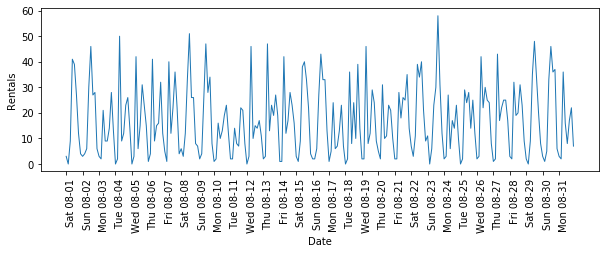

In [3]:
plt.figure(figsize=(10, 3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), freq='D') # only date for ticks
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")
plt.plot(citibike, linewidth=1)
plt.xlabel("Date")
plt.ylabel("Rentals")


In [4]:
y = citibike.values # target values -> rentals
X = citibike.index.strftime("%s").astype("int").to_numpy().reshape(-1, 1)

In [5]:
n_train = 184

def eval_on_features(features, target, regressor):
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(10, 3))
    
    plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90, ha="left")
    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="test")
    plt.plot(range(n_train), y_pred_train, '--', label="prediction train")
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label="prediction test")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel("Rentals")

Test-set R^2: -0.04


<Figure size 432x288 with 0 Axes>

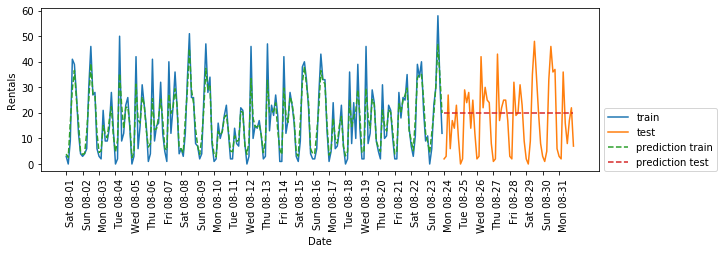

In [6]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
plt.figure()
eval_on_features(X, y, regressor)


Test-set R^2: 0.60


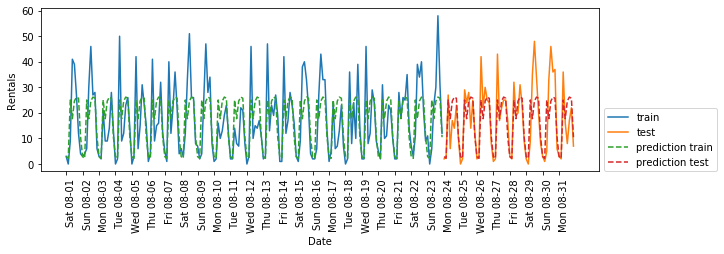

In [7]:
# only use day and hour

X_hour = citibike.index.hour.to_numpy().reshape(-1, 1)
eval_on_features(X_hour, y, regressor)


Test-set R^2: 0.84


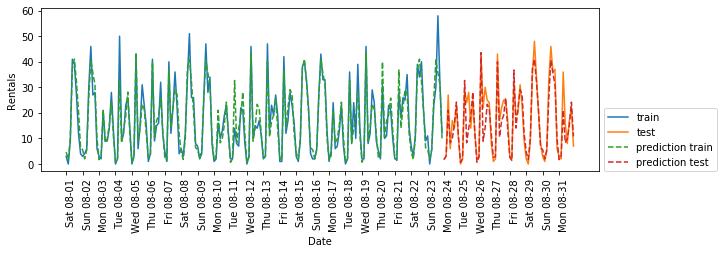

In [8]:
X_hour_week = np.hstack([citibike.index.dayofweek.to_numpy().reshape(-1, 1),
                        citibike.index.hour.to_numpy().reshape(-1, 1)])
eval_on_features(X_hour_week, y, regressor)

Test-set R^2: 0.13


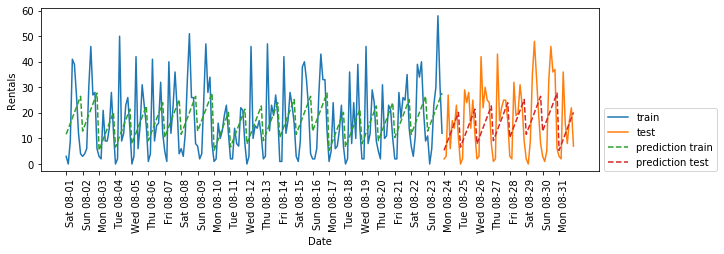

In [9]:
# try linear regression
from sklearn.linear_model import LinearRegression, Ridge
eval_on_features(X_hour_week, y, LinearRegression())
# result is wierd becasue of using integer which is categorical variable.

/Users/yunhongmin/.pyenv/versions/3.7.4/envs/data-science/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Test-set R^2: 0.62


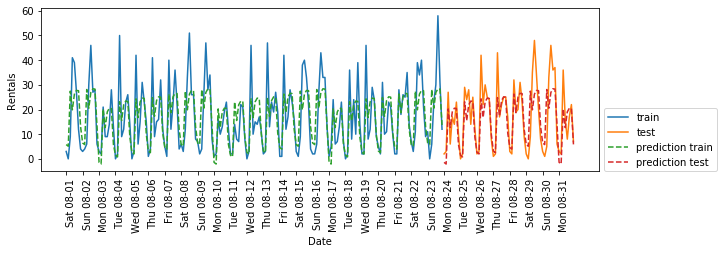

In [10]:
# using OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()
eval_on_features(X_hour_week_onehot, y, Ridge())

Test-set R^2: 0.85


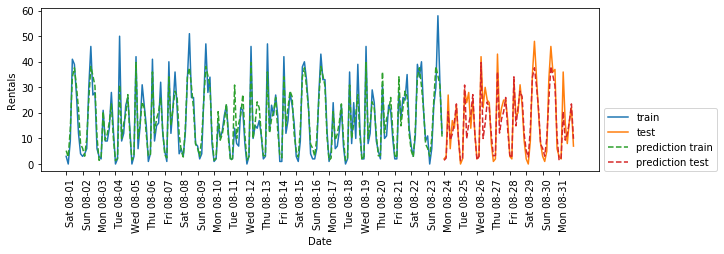

In [11]:
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)

In [12]:
hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["Mon", "Tue", "Wen", "Thu", "Fri", "Sat", "Sun"]
features = hour + day

In [13]:
features_poly = poly_transformer.get_feature_names(features)
features_nonzero = np.array(features_poly)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

Text(0, 0.5, 'Feature')

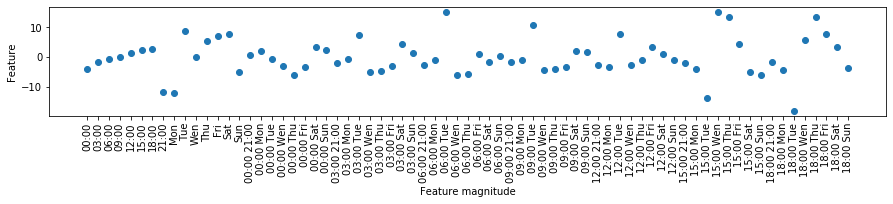

In [14]:
plt.figure(figsize=(15, 2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel("Feature magnitude")
plt.ylabel("Feature")